# Emojifier -- using word vector representations to make text messages more expressive

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1-EH_wrBtgfe4veU2SDQRGh7g3BsparlF?usp=sharing)

## Import libraries

In [1]:
!pip3 install emoji
import numpy as np
import pandas as pd
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Read in data

In [2]:
# Training data

train_data = pd.read_csv('/content/drive/MyDrive/Colab_notebooks/emojify_text/data/train_emoji.csv', usecols=['text', 'label'])
print(train_data.head())

train_X, train_Y = train_data['text'], train_data['label']

                              text  label
0           never talk to me again      3
1  I am proud of your achievements      2
2   It is the worst day in my life      3
3                 Miss you so much      0
4                     food is life      4


In [3]:
# Test data

test_data = pd.read_csv('/content/drive/MyDrive/Colab_notebooks/emojify_text/data/test.csv')
print(test_data.head())

test_X, test_Y = test_data['text'], test_data['label']

                        text  label
0              I want to eat      4
1          he did not answer      3
2   he got a very nice raise      2
3  she got me a nice present      2
4   ha ha ha it was so funny      2


## Baseline model - word embeddings

In [4]:
# Emojy labels dictionary

emoji_dictionary = {"0": ":red_heart:",
                    "1": ":soccer_ball:",
                    "2": ":grinning_face_with_big_eyes:",
                    "3": ":disappointed_face:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    '''
    Convert label (int or string) into corresponding emoji
    '''
    return emoji.emojize(emoji_dictionary[str(label)])

label_to_emoji(1)

'⚽'

In [5]:
# Preview training data 

for i in range(10):
    print(train_X[i], label_to_emoji(train_Y[i]))

never talk to me again 😞
I am proud of your achievements 😃
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying nonsense 😞
congratulations on your acceptance 😃
The assignment is too long  😞
I want to go play ⚽


### Transform labels to one hot representations

In [6]:
# Convert label to one-hot vector

def convert_to_one_hot(Y, C):
    '''
    Convert label series into a one-hot representation of shape(no examples, C)
    '''
    Y = np.eye(C)[Y]
    return Y

In [7]:
C = 5     # number of distinct labels

train_Y_oh = convert_to_one_hot(train_Y, C)
test_Y_oh = convert_to_one_hot(test_Y, C)

In [8]:
# Test convert_to_one_hot()

idx = 23
print(f"The text '{train_X[idx]}' has label index {train_Y[idx]} and emoji {label_to_emoji(train_Y[idx])}")
print(f"Label index {train_Y[idx]} in one-hot encoding is {train_Y_oh[idx]}")

The text 'It was funny lol' has label index 2 and emoji 😃
Label index 2 in one-hot encoding is [0. 0. 1. 0. 0.]


### GloVe embeddings
- Convert each word in the input sentence into word vector representations
- use pre-trained 50 dimensional GloVe  embeddings

In [9]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

#### GloVe embeddings contain:
- word_to_index: dictionary mapping from words to their indices in the vocabulary
- index_to_word: dictionary mapping from indices to their corresponding words in the vocabulary
- word_to_vec_map: dictionary mapping words to their GloVe vector representation.


In [10]:
word_to_index, index_to_word, word_to_vec = read_glove_vecs('/content/drive/MyDrive/Colab_notebooks/emojify_text/data/glove.6B.50d.txt')

In [11]:
# Test out embeddings

word = 'water'
idx = 999

print('The index of', word, 'in the vocabulary is', word_to_index[word])
print('The', str(idx), 'th word in the vocabulary is', index_to_word[idx])

The index of water in the vocabulary is 383772
The 999 th word in the vocabulary is .169


#### Average vector encoding 

In [12]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    # Split sentence into list of lower case words
    words = sentence.lower().split()

    # Initialize the average word vector
    avg = np.zeros(word_to_vec_map[words[0]].shape)
    
    # Average the word vectors
    total = 0
    for w in words:
        total += word_to_vec_map[w]
    avg = total / len(words)

    return avg

In [13]:
avg = sentence_to_avg('I love sunsets', word_to_vec)
print('I love sunsets encoding average: \n', avg)

I love sunsets encoding average: 
 [ 0.10978333  0.57714    -0.673831   -0.28422667  0.29515333 -0.13805667
 -0.23757967  0.09000013 -0.46179933  0.67011919 -0.51072667  0.54014
 -0.21834    -0.10426267  0.72390933 -0.10670667  0.23843     0.05800667
 -0.30102167 -0.59669967 -0.48771     0.90600667  0.65156    -0.12264667
  1.14354667 -0.94526667 -1.22976667  0.46481333  0.96599333 -0.91517333
  1.95159667  0.66615333 -0.45729333  0.1167     -0.19312067 -0.18638
  0.02023667  0.07492533 -0.23407667 -0.35408667 -0.26284777 -0.03138933
 -0.07115333  0.13088706 -0.051248    0.10733333  0.00900467 -0.94382
 -0.08204333  0.28222667]


### Build model

In [14]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((50,))
        for w in words:
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred


def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -(np.sum(Y_oh[i] * np.log(a)))
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

#### Test model

In [15]:
print(train_X.shape)
print(train_Y.shape)
print(np.eye(5)[train_Y].shape)
print(train_X[0])
print(type(train_X))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[train_Y].shape)
print(type(train_X))


(132,)
(132,)
(132, 5)
never talk to me again
<class 'pandas.core.series.Series'>
(20,)
(20,)
(132, 5)
<class 'pandas.core.series.Series'>


In [16]:
pred, W, b = model(train_X.to_numpy(), train_Y.to_numpy(), word_to_vec)
print(pred[:5])


Epoch: 0 --- cost = 1.9522788122278665
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.0796627681081378
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04475020701375957
Accuracy: 0.9621212121212122
Epoch: 300 --- cost = 0.03452480553386658
Accuracy: 0.9696969696969697
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]]


In [17]:
print("Training set:")
pred_train = predict(train_X.to_numpy(), train_Y.to_numpy(), W, b, word_to_vec)
print('Test set:')
pred_test = predict(test_X.to_numpy(), test_Y.to_numpy(), W, b, word_to_vec)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


In [18]:
def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))

In [19]:
X_my_sentences = np.array(["i adore you", 
                           "i love you", 
                           "funny lol", 
                           "lets play with a ball", 
                           "food is ready", 
                           "not feeling joyful"])

Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😃
lets play with a ball ⚽
food is ready 🍴
not feeling joyful 😃


## LSTM model using Keras

In [20]:
import numpy as np
np.random.seed(1)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform


This model:  
- will be able to account for the word ordering.
- will continue to use pre-trained word embeddings to represent words.

We will feed word embeddings into an LSTM.
The LSTM will learn to predict the most appropriate emoji.

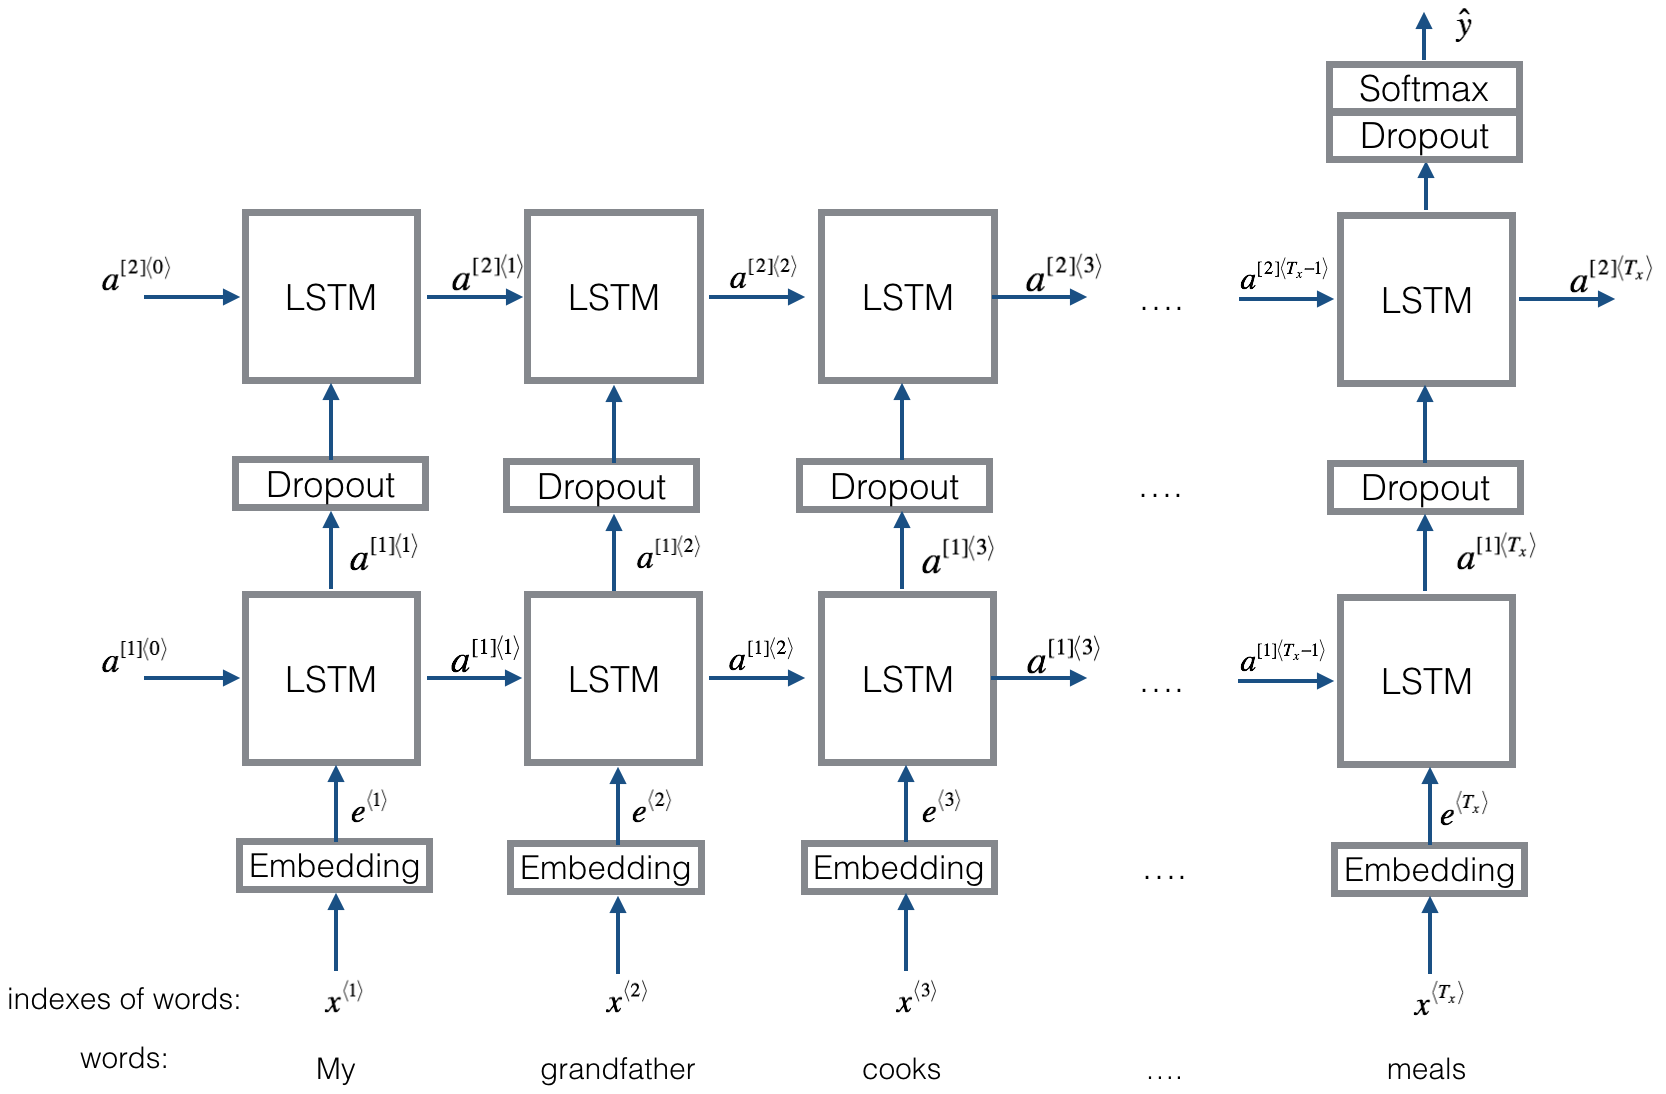


In [21]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples

    # Initialize X_indices as a numpy matrix of zeros
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1
            
    return X_indices

In [22]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [23]:
def pretrained_embedding_layer(word_to_vec, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = 50                                        # define dimensionality of GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec[word]

    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(input_dim = vocab_len, output_dim = emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. The layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [24]:
embedding_layer = pretrained_embedding_layer(word_to_vec, word_to_index)
print("weights[0][2][3] =", embedding_layer.get_weights()[0][2][3])

weights[0][2][3] = 0.056907


In [25]:
def Emojify_V2(input_shape, word_to_vec, word_to_index):
    """
    Function creating the model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(units = 5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices], outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [26]:
max_len = len(max(train_X, key=len).split())

model = Emojify_V2((max_len,), word_to_vec, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 10, 50)            20000050  
                                                                 
 lstm (LSTM)                 (None, 10, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645   

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
train_X_indices = sentences_to_indices(train_X, word_to_index, max_len)


In [29]:
model.fit(train_X_indices, train_Y_oh, epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 3s 21ms/step - loss: 1.5886 - accuracy: 0.2955
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 1.5132 - accuracy: 0.3409
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 1.4440 - accuracy: 0.4167
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 1.3701 - accuracy: 0.4318
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 1.2369 - accuracy: 0.5909
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 1.1713 - accuracy: 0.5682
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 0.9515 - accuracy: 0.6288
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 0.9544 - accuracy: 0.5985
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 0.7714 - accuracy: 0.7273
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss: 0.7276 - accuracy: 0.6970
Epoch 11/50
5/5 [============

In [30]:
test_X_indices = sentences_to_indices(test_X, word_to_index, max_len)

loss, acc = model.evaluate(test_X_indices, test_Y_oh)
print(acc)

2/2 [==============================] - 1s 14ms/step - loss: 0.6455 - accuracy: 0.8393
0.8392857313156128


In [31]:
pred = model.predict(test_X_indices)
for i in range(len(test_X)):
    x = test_X_indices
    num = np.argmax(pred[i])
    if(num != test_Y[i]):
        print('Expected emoji:'+ label_to_emoji(test_Y[i]) + ' prediction: '+ test_X[i] + label_to_emoji(num).strip())

Expected emoji:😃 prediction: she got me a nice present❤️
Expected emoji:😞 prediction: work is hard😃
Expected emoji:😞 prediction: This girl is messing with me❤️
Expected emoji:😞 prediction: work is horrible😃
Expected emoji:🍴 prediction: any suggestions for dinner😃
Expected emoji:❤️ prediction: I love taking breaks😞
Expected emoji:😃 prediction: you brighten my day❤️
Expected emoji:😞 prediction: she is a bully❤️
Expected emoji:😃 prediction: will you be my valentine❤️
